<a href="https://colab.research.google.com/github/amanu242006/FAC-task-3/blob/main/FAC_task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Found subfolders: ['01Jan-Nifty', '02Feb-Nifty', '03Mar-Nifty', '04Apr-Nifty', '05May-Nifty', '06June-Nifty', '07July-Nifty', '08Aug-Nifty', '09Sept-Nifty', '10Oct-Nifty', '11Nov-Nifty', '12Dec-Nifty']

🔄 Processing folder: 01Jan-Nifty

🔄 Processing folder: 02Feb-Nifty

🔄 Processing folder: 03Mar-Nifty

🔄 Processing folder: 04Apr-Nifty

🔄 Processing folder: 05May-Nifty

🔄 Processing folder: 06June-Nifty
❌ Error processing 18200: If using all scalar values, you must pass an index

🔄 Processing folder: 07July-Nifty

🔄 Processing folder: 08Aug-Nifty

🔄 Processing folder: 09Sept-Nifty

🔄 Processing folder: 10Oct-Nifty

🔄 Processing folder: 11Nov-Nifty

🔄 Processing folder: 12Dec-Nifty
✅ Total Trades: 152
🏆 Winning Trades: 110
💥 Losing Trades: 42
📊 Net PnL: 2039595.0
📅 Trades by Month:
 Month
12Dec-Nifty     23
10Oct-Nifty     16
09Sept-Nifty    15
02Feb-Nifty  

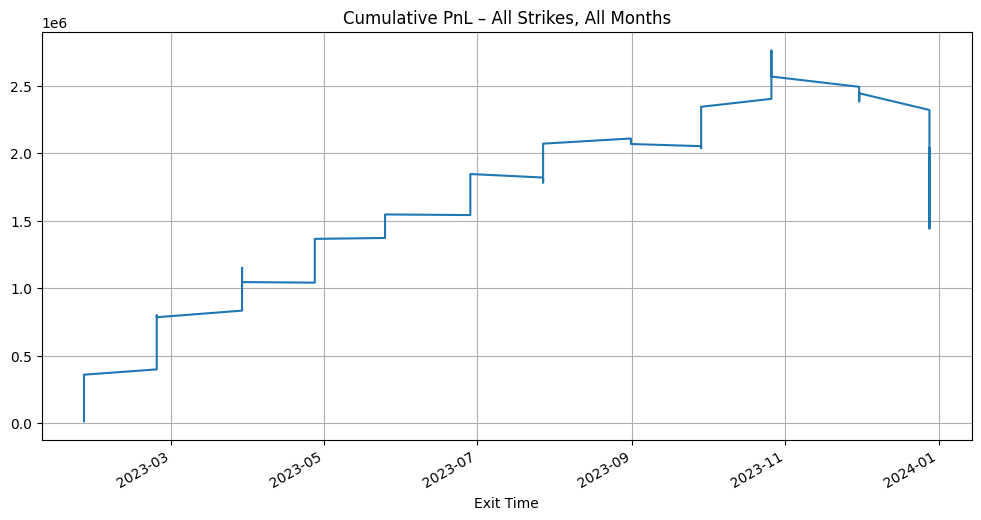

In [104]:
# ✅ Multi-Strike ATM Straddle/Strangle Backtest: All Matching Call/Put Pairs Per Month

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Imports
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Step 3: Set paths
spot_path = "/content/drive/MyDrive/OptionBacktest2023/NIFTY2023/NIFTY_cash.csv"
option_base_path = "/content/drive/MyDrive/OptionBacktest2023"

# Step 4: Load Spot Data
spot_df = pd.read_csv(spot_path, parse_dates=["datetime"])
spot_df = spot_df[["datetime", "close"]].rename(columns={"close": "spot_price"})
spot_df["spot_price"] = pd.to_numeric(spot_df["spot_price"], errors="coerce")

# Step 5: Extract Expiry Date from Filename
def extract_expiry_from_filename(path):
    match = re.search(r'(\d{4}-\d{2}-\d{2})', path)
    if match:
        return pd.to_datetime(match.group(1))
    return None

# Step 6: Load All Matching Strikes per Month
all_trades = []

def load_strike_pairs(folder):
    call_files = glob.glob(os.path.join(folder, "*_call_*.json"))
    put_files = glob.glob(os.path.join(folder, "*_put_*.csv"))

    call_map = {re.search(r'(\d+)_call', os.path.basename(f)).group(1): f for f in call_files}
    put_map = {re.search(r'(\d+)_put', os.path.basename(f)).group(1): f for f in put_files}

    common_strikes = sorted(set(call_map.keys()) & set(put_map.keys()))
    expiry = extract_expiry_from_filename(call_files[0]) if call_files else None
    return [(strike, call_map[strike], put_map[strike], expiry) for strike in common_strikes]

# Step 7: Strategy Function

def run_strategy(df, expiry_date, sl_pct=0.25, tp_pct=0.5, atr_threshold=2):
    trades = []
    position = None
    entry_price = None
    entry_time = None
    position_type = None

    for i in range(1, len(df)):
        row = df.iloc[i]
        current_time = row.name
        spot = row['spot_price']

        if row['ATR'] < atr_threshold:
            continue

        atm_strike = row['strike']
        otm_call_strike = atm_strike + 200
        otm_put_strike = atm_strike - 200

        otm_call_row = df[(df.index == current_time) & (df['strike'] == otm_call_strike)]
        otm_put_row = df[(df.index == current_time) & (df['strike'] == otm_put_strike)]

        straddle_premium = row['call_price'] + row['put_price']
        strangle_premium = None
        if not otm_call_row.empty and not otm_put_row.empty:
            strangle_premium = otm_call_row['call_price'].values[0] + otm_put_row['put_price'].values[0]

        if position:
            current_premium = straddle_premium if position_type == "straddle" else strangle_premium or straddle_premium
            exit_due_to_sl_tp = (
                position == "long" and (current_premium >= entry_price * (1 + tp_pct) or current_premium <= entry_price * (1 - sl_pct))
            )
            force_exit = current_time.date() >= expiry_date.date()

            if exit_due_to_sl_tp or force_exit:
                pnl = ((current_premium - entry_price) if position == "long" else (entry_price - current_premium)) * 100
                trades.append({
                    "Entry Time": entry_time,
                    "Entry Date": entry_time.date(),
                    "Exit Time": current_time,
                    "Position": position.title(),
                    "Strategy": position_type,
                    "Strike": atm_strike,
                    "Entry Price": entry_price,
                    "Exit Price": current_premium,
                    "PnL": pnl,
                    "Forced Exit": force_exit
                })
                position = None

        if not position and current_time.date() < expiry_date.date():
            if spot > row['Upper_Band'] and strangle_premium:
                position = "long"
                entry_price = strangle_premium
                entry_time = current_time
                position_type = "strangle"
            elif spot < row['Lower_Band']:
                position = "short"
                entry_price = straddle_premium
                entry_time = current_time
                position_type = "straddle"

    return pd.DataFrame(trades)

# Step 8: Run for All Strikes in All Months
subfolders = sorted([
    f.path for f in os.scandir(option_base_path)
    if f.is_dir() and "NIFTY2023" not in f.name
])
print("📁 Found subfolders:", [os.path.basename(f) for f in subfolders])

for folder in subfolders:
    print(f"\n🔄 Processing folder: {os.path.basename(folder)}")
    strike_pairs = load_strike_pairs(folder)

    for strike, call_file, put_file, expiry in strike_pairs:
        try:
            call_raw = pd.read_json(call_file)
            call_df = pd.DataFrame(call_raw["Success"].tolist())
            call_df = call_df[["datetime", "strike_price", "close"]].rename(columns={"close": "call_price", "strike_price": "strike"})
            call_df["datetime"] = pd.to_datetime(call_df["datetime"])
            call_df["strike"] = call_df["strike"].astype(int)
            call_df["call_price"] = pd.to_numeric(call_df["call_price"], errors="coerce")

            put_df = pd.read_csv(put_file, parse_dates=["datetime"])
            put_df = put_df[["datetime", "strike_price", "close"]].rename(columns={"close": "put_price", "strike_price": "strike"})
            put_df["put_price"] = pd.to_numeric(put_df["put_price"], errors="coerce")
            put_df["strike"] = put_df["strike"].astype(int)

            df = call_df.merge(put_df, on=["datetime", "strike"], how="inner")
            df = df.merge(spot_df, on="datetime", how="inner")
            df.dropna(subset=["call_price", "put_price", "spot_price"], inplace=True)
            df.set_index("datetime", inplace=True)

            df['H-L'] = df['spot_price'].diff().abs()
            df['ATR'] = df['H-L'].rolling(window=10).mean()
            df['MA'] = df['spot_price'].rolling(window=10).mean()
            df['STD'] = df['spot_price'].rolling(window=10).std()
            df['Upper_Band'] = df['MA'] + 1.5 * df['STD']
            df['Lower_Band'] = df['MA'] - 1.5 * df['STD']
            df['strike'] = df['strike'].astype(int)

            if not df.empty:
                trades = run_strategy(df, expiry)
                if not trades.empty:
                    trades["Month"] = os.path.basename(folder)
                    trades["Strike File"] = strike
                    all_trades.append(trades)

        except Exception as e:
            print(f"❌ Error processing {strike}: {e}")

# Step 9: Summary
if all_trades:
    results = pd.concat(all_trades)
    results["Cumulative PnL"] = results["PnL"].cumsum()

    print("✅ Total Trades:", len(results))
    print("🏆 Winning Trades:", len(results[results['PnL'] > 0]))
    print("💥 Losing Trades:", len(results[results['PnL'] < 0]))
    print("📊 Net PnL:", round(results["PnL"].sum(), 2))
    print("📅 Trades by Month:\n", results["Month"].value_counts())

    results.set_index("Exit Time")["Cumulative PnL"].plot(
        figsize=(12, 6), title="Cumulative PnL – All Strikes, All Months")
    plt.grid(True)
    plt.show()
else:
    print("❌ No trades executed across all months.")




